# Prepare transition matrix for different groups

In [1]:
import pandas as pd

path = '../example_datasets/train.csv'
df = pd.read_csv(path)
settings = {}


Firstly, we need to add spleepage

In [2]:
from sklearn.mixture import GaussianMixture
import retentioneering
import numpy as np

def _calc_thresholds(df, target_event='lost', n_components=2):
    if 'time_to_next_event' not in df.columns:
        tmp = retentioneering.analysis.get_shift(df.copy())
    else:
        tmp = df.copy()
    model = GaussianMixture(n_components=n_components)
    model.fit(np.log(tmp[tmp.next_event != target_event].time_to_next_event / 1e6).values.reshape(-1, 1))

    thresh = {}
    for i in [-i for i in range(1000)] + list(range(1000)):
        thresh.update({i / 100: model.predict_proba([[i / 100]])[0].argmax()})
    th = pd.Series(thresh).reset_index()
    th.columns = ['thresh', 'cluster']

    th = th.sort_values('thresh')
    right_th = th.groupby('cluster').max()
    right_th.thresh = np.exp(right_th.thresh)
    right_th.loc[0] = {'thresh': 1, 'cluster': 0}
    right_th.loc[1] = {'thresh': np.exp(7), 'cluster': 1}
    if right_th.shape[0] < 3:
        right_th = right_th.append({'thresh': np.exp(20), 'cluster': 2}, ignore_index=True)
    return tmp, right_th.sort_values('thresh')


def _calc_sleep_class(df, target_event='lost'):
    df, right_th = _calc_thresholds(df, target_event=target_event)
    df['sleep_class'] = None
    for idx, th in enumerate(right_th.thresh.iloc[:-1]):
        df.sleep_class = np.where(df.sleep_class.isnull() &
                                  (df.time_to_next_event / 1e6 <= th),
                                  'class' + str(idx), df.sleep_class)
    df.sleep_class = np.where(df.sleep_class.isnull(), 'class' + str(idx + 1), df.sleep_class)
    return df, idx + 2


def _add_sleep_class(df, class_id):
    sub_pos = df[df.sleep_class != 'class' + str(class_id)].copy().reset_index(drop=True)

    sub0first = df[df.sleep_class == 'class' + str(class_id)].copy().reset_index(drop=True)
    sub0second = sub0first.copy()

    sub0first.next_event = 'sleep_' + str(class_id)
    sub0first.time_to_next_event = 1

    sub0second.event_name = 'sleep_' + str(class_id)
    sub0second.event_timestamp += 1

    sub0 = sub0first.append(sub0second, ignore_index=True)
    return sub0

def add_sleep_class(df, target_event='lost'):
    if 'sleep_class' not in df.columns:
        df, max_class_id = _calc_sleep_class(df, target_event=target_event)
    else:
        max_class_id = int(df.sleep_class.max()[-1]) + 1
    res = []
    for class_id in range(max_class_id):
        res.append(_add_sleep_class(df, class_id))
    return pd.concat(res, ignore_index=True).reset_index(drop=True)


In [3]:
df2 = add_sleep_class(df)
sub = df2[df2.next_event.isin(['passed', 'lost'])].copy()
sub.event_timestamp += sub.time_to_next_event
sub.event_name = sub.next_event
df2 = df2.append(sub, ignore_index=True).reset_index(drop=True)
df2 = df2.drop_duplicates(['event_name', 'event_timestamp']).drop_duplicates()


## Clustering groups

Count map

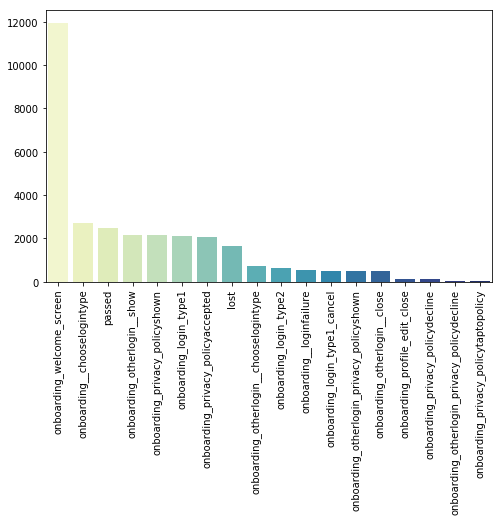

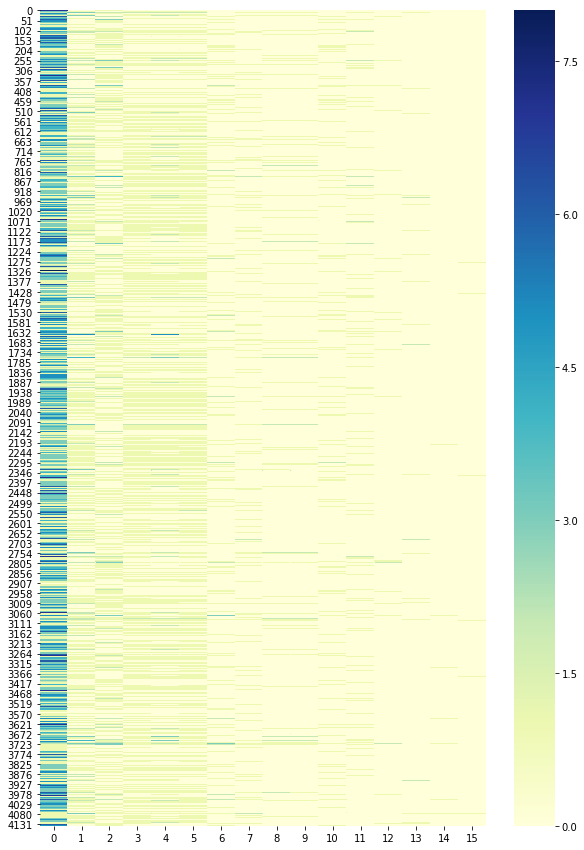

In [4]:
from retentioneering import analysis
# Also for our clickstream we could calculate count of all events for every user and plot heatmap
countmap = analysis.calculate.calculate_frequency_map(df, settings)

Projection of clusters

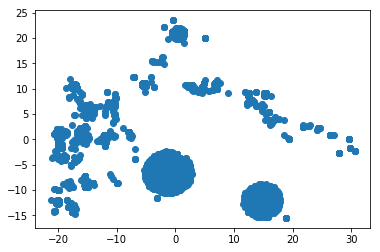

In [5]:
from MulticoreTSNE import MulticoreTSNE as TSNE
from matplotlib import pyplot as plt
% matplotlib inline


tsne = TSNE(perplexity=100, n_jobs=8).fit_transform(countmap.values)
plt.scatter(tsne[:, 0], tsne[:, 1])


Clusterer

8


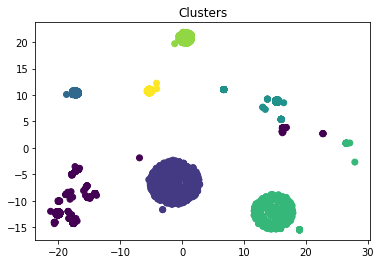

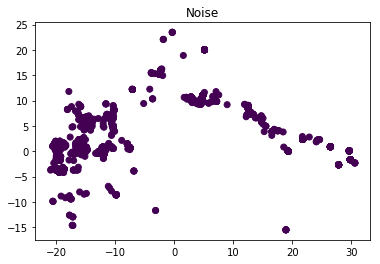

In [6]:
from hdbscan import HDBSCAN

hdbscan = HDBSCAN(alpha=6., min_cluster_size=150, )
hdbscan.fit(countmap.values)
print(len(set(hdbscan.labels_)))
plt.title('Clusters')
plt.scatter(tsne[hdbscan.labels_ != -1][:, 0], tsne[hdbscan.labels_ != -1][:, 1],
            c=hdbscan.labels_[hdbscan.labels_ != -1])
plt.show()
plt.title('Noise')
plt.scatter(tsne[hdbscan.labels_ == -1][:, 0], tsne[hdbscan.labels_ == -1][:, 1],
            c=hdbscan.labels_[hdbscan.labels_ == -1])
plt.show()


In [8]:
def build_cluster_stats(df2, cluster, countmap, clusters):
    users = countmap[clusters == cluster].index.values
    sub = df2[df2.user_pseudo_id.isin(users)].copy()
    res = analysis.get_desc_table(sub, settings, plot=False)

    sub['event_rank'] = 1
    sub = sub.sort_values('event_timestamp')
    sub.event_rank = sub.groupby('user_pseudo_id').event_rank.cumsum()
    sub.time_to_next_event = np.log(sub.time_to_next_event + 1e-6)

    dtm = sub[sub.next_event != 'lost'].groupby('event_rank').time_to_next_event.mean().rename('dt_mean')
    dtstd = sub[sub.next_event != 'lost'].groupby('event_rank').time_to_next_event.std().rename('dt_std')
    dt = dtm.reset_index().join(dtstd, on='event_rank')
    dt.index = dt.event_rank.astype(int).values
    dt = dt.drop('event_rank', 1)

    res = res.T.join(dt)
    #     res.loc[:, ['dt_mean', 'dt_std']] = res.loc[:, ['dt_mean', 'dt_std']].shift(1)
    stats = pd.DataFrame(columns=['sleep_type', 'mean_', 'std_'])
    for sleep in ['sleep_0', 'sleep_1', 'sleep_2']:
        stats = stats.append({
            'sleep_type': sleep,
            'mean_': np.log(sub[sub.event_name == sleep].time_to_next_event).mean(skipna=True),
            'std_': np.log(sub[sub.event_name == sleep].time_to_next_event).std(skipna=True),
            'users_count': len(users)
        }, ignore_index=True)
    return res.T, stats


In [9]:
import os

path = './experiments/track-simulator/'
if not os.path.exists(path):
    os.mkdir(path)
if not os.path.exists(path + 'dynamic_matrix/'):
    os.mkdir(path + 'dynamic_matrix/')
if not os.path.exists(path + 'stats/'):
    os.mkdir(path + 'stats/')

df2.time_to_next_event = df2.time_to_next_event / 1e6
for cluster in set(hdbscan.labels_):
    x, y = build_cluster_stats(df2, 0, countmap, hdbscan.labels_)
    x.to_csv(path + 'dynamic_matrix/cluster_{}.csv'.format(cluster))
    y.to_csv(path + 'stats/cluster_{}.csv'.format(cluster))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: RuntimeWarning:

invalid value encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: RuntimeWarning:

invalid value encountered in log



# Simulation

In [14]:
import numpy as np


class Agent:
    def __init__(self, probs, user_type, user_id=None):
        self._mean_time = probs.loc['dt_mean']
        self._std_time = probs.loc['dt_std']
        self._probs = probs.drop(['dt_mean', 'dt_std', 'Accumulated Lost', 'Accumulated Passed'])
        self._probs = self._probs / self._probs.sum(0)
        self._state = 1
        self.user_type = user_type
        if user_id is None:
            user_id = np.random.randint(1e12)
        self.user_id = user_id
        self._track = pd.DataFrame(columns=['user_pseudo_id', 'event_timestamp', 'event_name', 'user_type'])
        self._current_time = 0

    def _step(self):
        probs = self._probs.loc[:, str(self._state)]
        vals = probs.index
        probs = probs.values
        next_step = np.random.choice(vals, p=probs)
        return next_step

    def _delay(self):
        mu = self._mean_time.loc[str(self._state)]
        sigma = self._std_time.loc[str(self._state)]
        time = np.random.normal(loc=mu, scale=sigma, size=1)[0]
        return np.exp(time + 1e-6)

    def simulate(self):
        while (self._state != -1) and (self._state < self._probs.shape[1]):
            self._current_time += self._delay()
            event = self._step()
            self._track = self._track.append({
                'user_pseudo_id': self.user_id,
                'event_timestamp': self._current_time,
                'event_name': event,
                'user_type': self.user_type
            }, ignore_index=True)
            if event != 'lost':
                self._state += 1
            else:
                self._state = -1
        return self._track


In [15]:
class Simulator:
    def __init__(self, path, pops=None):
        self._population = self.create_population(path, pops)
        self.clickstream = pd.DataFrame(columns=['user_pseudo_id', 'event_timestamp', 'event_name', 'user_type'])

    def create_population(self, path, pops=None):
        dyn_mat = os.path.join(path, 'dynamic_matrix')
        stats = os.path.join(path, 'stats')
        files = os.listdir(dyn_mat)
        agents = []
        for idx, file in enumerate(sorted(files)):
            if pops is None:
                agents_num = pd.read_csv(os.path.join(stats, file)).users_count.iloc[0]
            else:
                agents_num = pops[idx]
            clus_dyn = pd.read_csv(os.path.join(dyn_mat, file), index_col=[0])
            for i in range(agents_num):
                agents.append(Agent(clus_dyn, file.split('_')[1].split('.')[0]))
        return agents

    def simulate(self):
        for agent in self._population:
            self.clickstream = self.clickstream.append(agent.simulate())
        return self.clickstream


In [28]:
sim = Simulator(path, [100] * 10)
clicks = sim.simulate()

In [35]:
clicks.head()

,user_pseudo_id,event_timestamp,event_name,user_type,event_rank
0,694017314218,0.000002,onboarding_welcome_screen,-1,1
1,694017314218,8.253703,sleep_1,-1,1
2,694017314218,8.253705,onboarding__chooseLoginType,-1,1
3,694017314218,9.491023,sleep_0,-1,1
4,694017314218,9.491025,onboarding_privacy_policyShown,-1,1


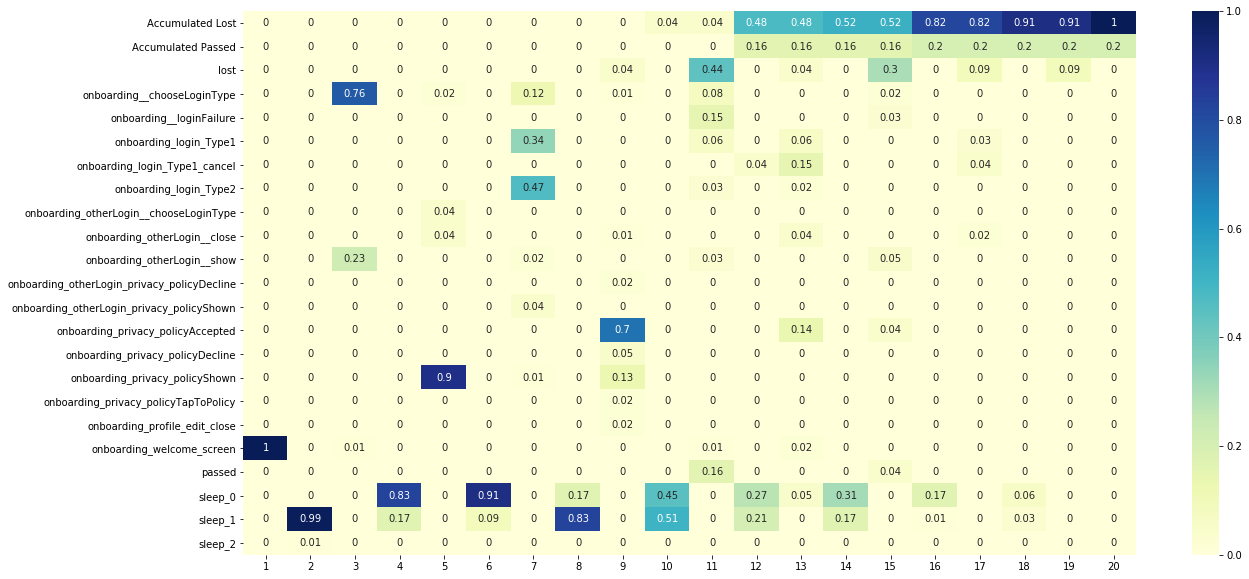

In [29]:
analysis.get_desc_table(clicks[clicks.user_type == '-1'], settings={});


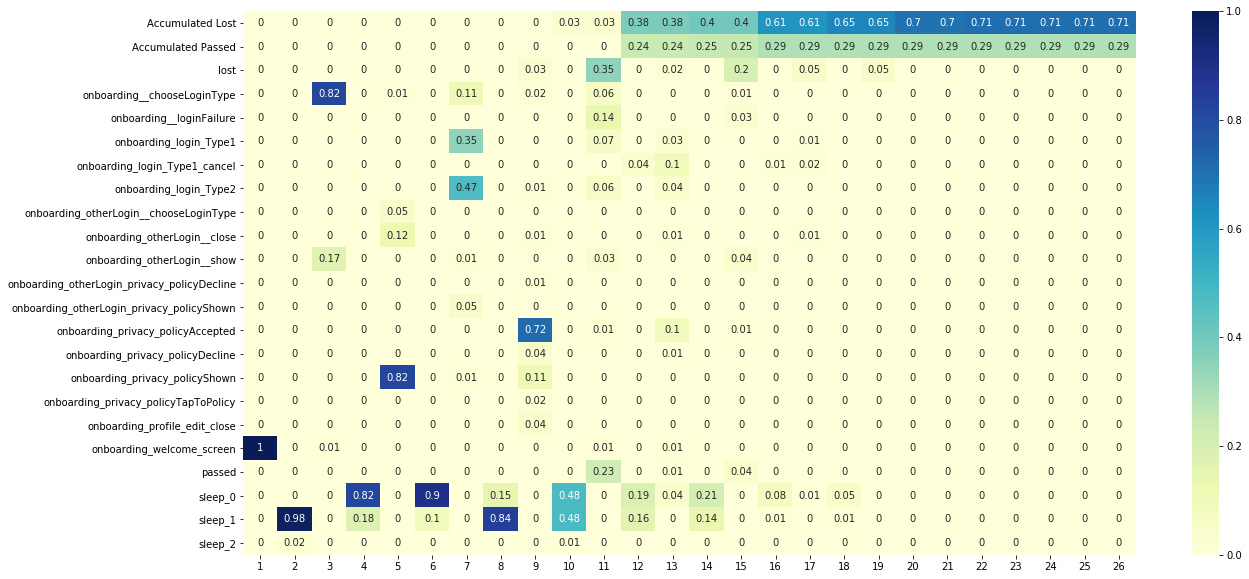

In [27]:
import seaborn as sns

sns.mpl.pyplot.rcParams['figure.figsize'] = [20, 10]
sns.heatmap(pd.read_csv('./experiments/track-simulator/dynamic_matrix/cluster_-1.csv',
                        index_col=0).drop(['dt_mean', 'dt_std']), annot=True, cmap="YlGnBu")
